<a href="https://colab.research.google.com/github/MichSteczko/Kaggle_competitions-/blob/main/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab import drive
from tensorflow import keras
drive.mount('/content/drive')

Mounted at /content/drive


# Checking the data

In [2]:
import tensorflow as tf
from sklearn.datasets import load_digits


In [3]:
path = "/content/drive/MyDrive/Mnist"
train_data = pd.read_csv(path+"/train.csv")

In [4]:
train_data.shape

(42000, 785)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split

In [6]:
Y = train_data['label']
X = train_data.drop(labels = 'label', axis=1)
X = X/255.0 # setting up pixel range between 0 and 1

In [7]:
X = tf.reshape(X, (42000, 28,28,1)).numpy()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=2)

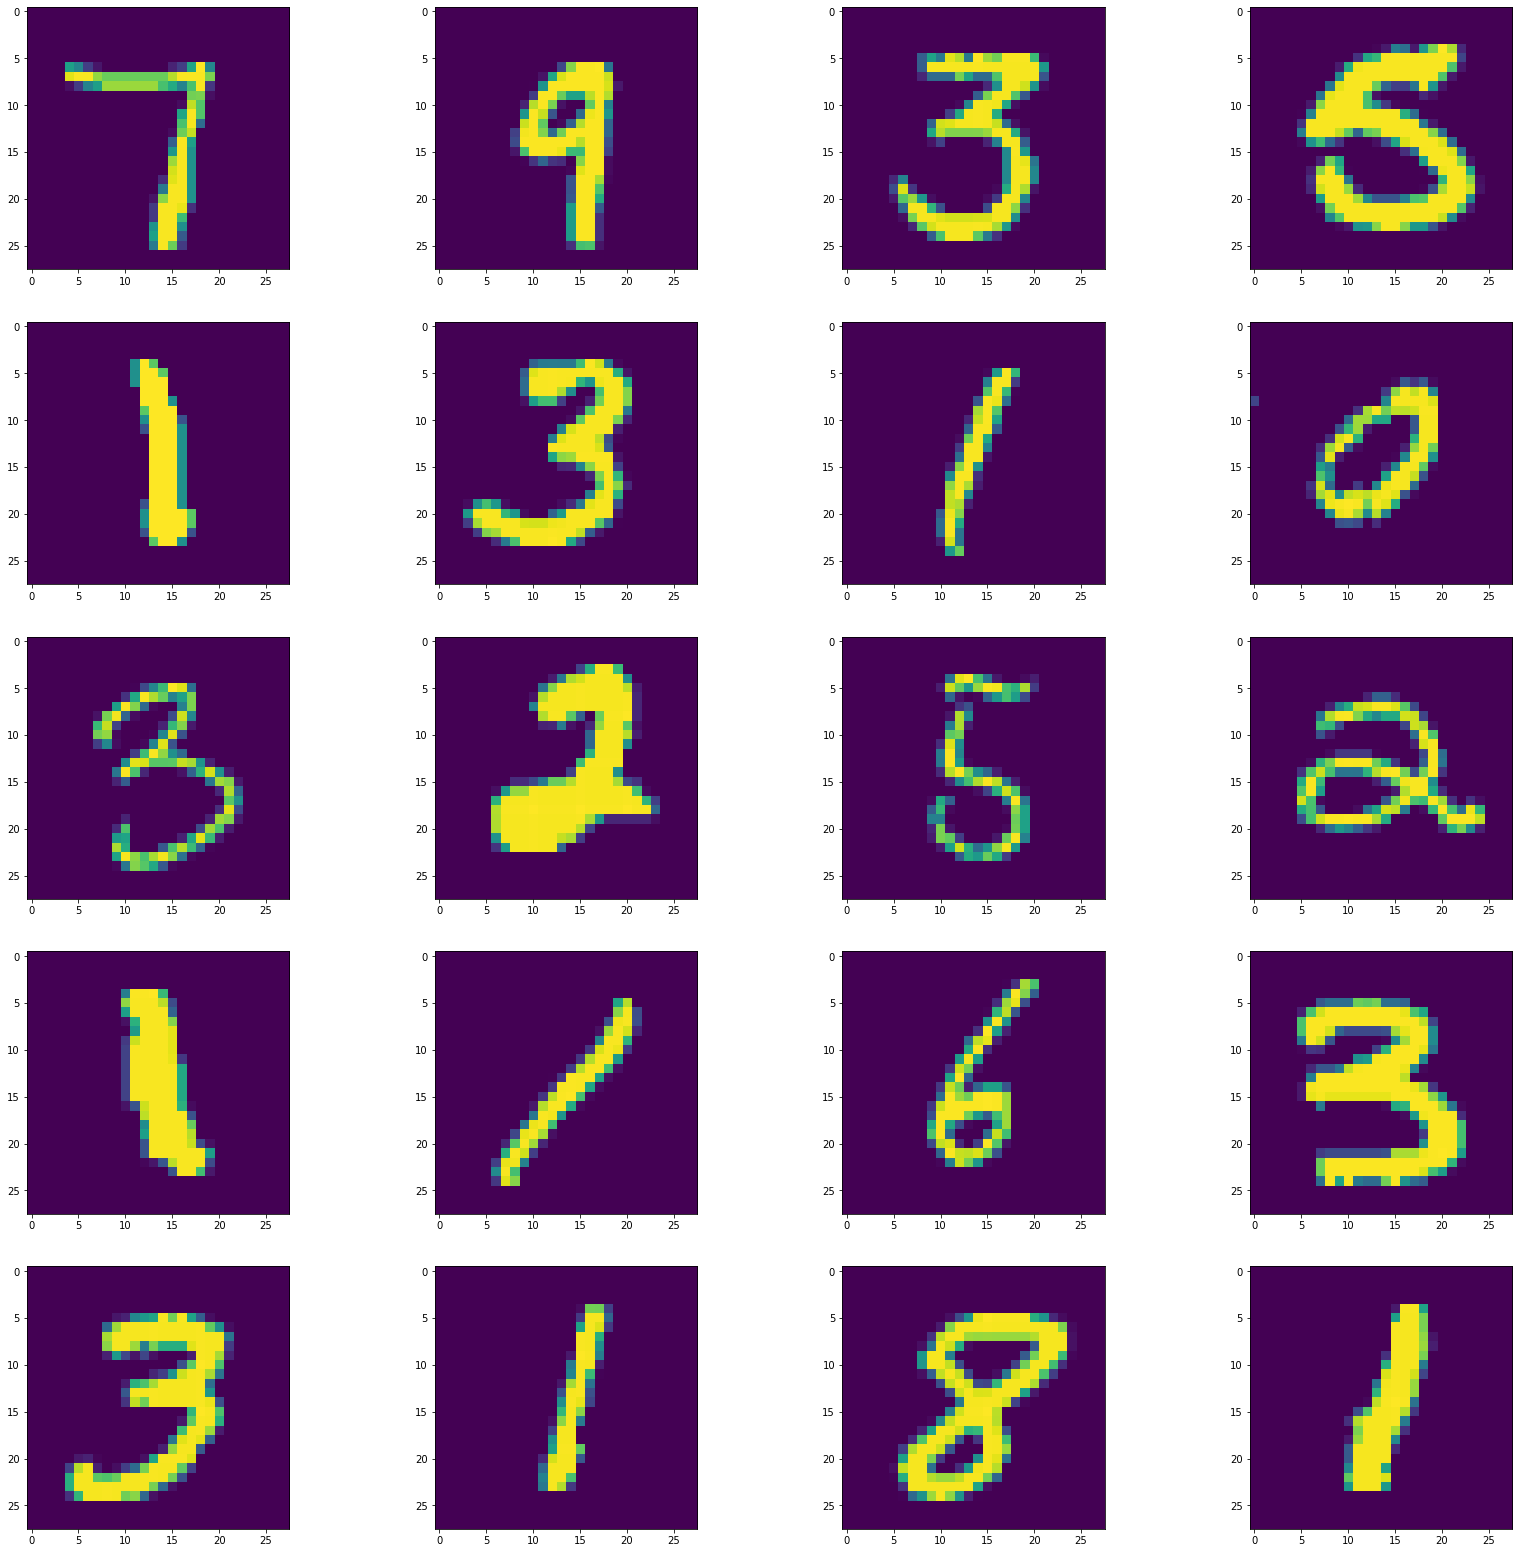

In [8]:
img = 0
columns = 4
rows = 5
fig = plt.figure(figsize=(28,28))
for i in range(1, columns*rows +1):
    img = X_train[i][:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Training the data

In [9]:
# this type of neural net is "self-normalizing" net with lecun kernel and alphadroput and one-cycle learing method

cnn = keras.models.Sequential()
cnn.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='selu', input_shape=[28, 28,2], kernel_initializer='lecun_normal'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.AlphaDropout(0.1)) # when we use selu activation function we have to use Alphadroput for better effect
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='selu', kernel_initializer='lecun_normal'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.AlphaDropout(0.1))
cnn.add(tf.keras.layers.Flatten(input_shape=[28, 28,1]))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dense(units=200, activation='selu', kernel_initializer='lecun_normal'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.AlphaDropout(0.1))
cnn.add(keras.layers.Dense(10, activation="softmax"))

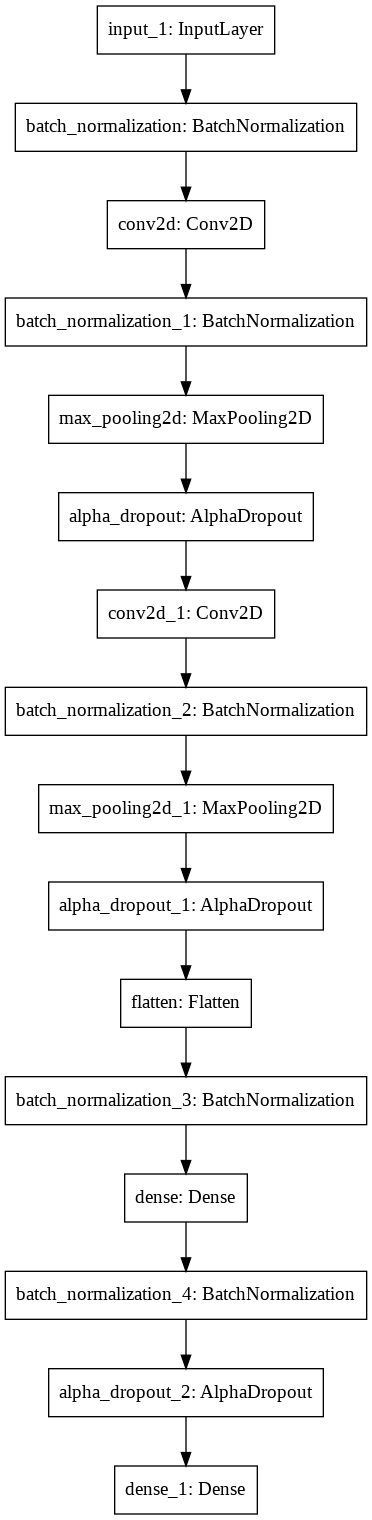

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(cnn)

In [12]:
optimizer = keras.optimizers.Nadam()
cnn.compile(loss="sparse_categorical_crossentropy",
optimizer=optimizer,
metrics=["accuracy"]
)

In [13]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [14]:
import math
n_epochs = 25
batch_size = 128
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.01, start_rate=0.001)

In [15]:
history = cnn.fit(X_train, Y_train, 
validation_data=(X_val, Y_val), 
batch_size = batch_size,
epochs=n_epochs,
callbacks=[onecycle]
)

Epoch 1/25
296/296 [==============================] - 46s 147ms/step - loss: 0.5919 - accuracy: 0.8114 - val_loss: 0.1650 - val_accuracy: 0.9569
Epoch 2/25
296/296 [==============================] - 43s 145ms/step - loss: 0.1029 - accuracy: 0.9665 - val_loss: 0.1027 - val_accuracy: 0.9731
Epoch 3/25
296/296 [==============================] - 43s 147ms/step - loss: 0.0707 - accuracy: 0.9781 - val_loss: 0.0930 - val_accuracy: 0.9798
Epoch 4/25
296/296 [==============================] - 43s 146ms/step - loss: 0.0542 - accuracy: 0.9835 - val_loss: 0.0631 - val_accuracy: 0.9855
Epoch 5/25
296/296 [==============================] - 44s 148ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.0761 - val_accuracy: 0.9838
Epoch 6/25
296/296 [==============================] - 43s 145ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.0975 - val_accuracy: 0.9783
Epoch 7/25
296/296 [==============================] - 43s 144ms/step - loss: 0.0356 - accuracy: 0.9884 - val_loss: 0.0970 - val_ac

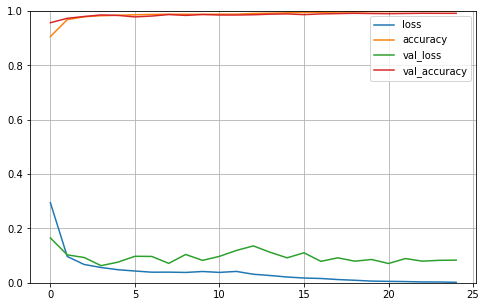

In [16]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [17]:
test_data = pd.read_csv(path+"/test.csv")
test_data = test_data /255.0
test_data.shape
test_data = tf.reshape(test_data, (28000,28,28,1))
preds = cnn.predict(test_data)

In [18]:
results = np.argmax(preds,axis = 1)
results = pd.Series(results,name="Label")
results[0]

2

In [19]:
sample_submission = pd.read_csv(path+"/sample_submission.csv", index_col='ImageId')
sample_submission['Label'] = results
sample_submission.to_csv(path+"/sample2.csv")

In [20]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv(path+"/cnn_mnist_submission.csv",index=False)